# COMP41680 - Ryan Jennings 19205824

This project takes a name of an Actor e.g. __Nicolas Cage__ or __Halle Berry__, and gathers the information for all their acting credits from **IMDB** before plotting the information and making predictions about their upcoming movies.

In [525]:
import csv
import json
import re

from typing import Any, Dict, List, Union

import requests
import seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from PIL import Image
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Use seaborn style plots
seaborn.set()

JsonType = Dict[str, Any]

<span style='color: red'>**API Chosen:**</span>

For this project I made use of 2 APIs and scraping 1 webpage.  
The first API I used was the IMDB suggestions API which seems to be the only publically available API they provide now which made this project a little difficult.  
The endpoint for this API was `https://sg.media-imdb.com/suggests/{first letter}/{search}.json`. It simply returns the search suggestions as you would get if you went to their home page and searched for an actor or show. See the example for searching __Nicolas Cage__ here: `https://sg.media-imdb.com/suggests/n/nicolas%20cage.json`.  

I used the suggestions API to get their IMDB actor Id. I used that Id find their unique webpage on IMDB. Then since IMDB didn't provide an API I had to scrape their webpage to find all the tv show and movie Ids that the actor has starred in (sorry IMDB system engineers I limited my time spent scraping as much as possible).  

When I had a list of all the IMDB tv show and movie Ids for a given actor I could make use of the main API.
The main API was `OMDB` which provides an API to the IMDB database for movies and tv shows based on a movie/tv Id. Their website with documentation and examples can be found here: `http://www.omdbapi.com/`.  I used this API to get as much information as possible about a movie/tv show to be used for later analysis.

The API key I used for OMDB was `7bab4d15`

I picked Nicolas for this project to do the analysis for but after reviewing all the content why not try it with your favourite actor? Simple change the `ACTOR_NAME` variable to you desired actor and continue through each section

In [3]:
OMDB_API_KEY: str = '7bab4d15'

In [4]:
ACTOR_NAME: str = 'Nicolas Cage'

In [7]:
def get_actor_imdb_info(name: str) -> JsonType:
    """
    For a given actor name return their IMDB data consisting of Name, Id and Image URL

    Keyword arguments:
    name: str - Name of actor that will be searched for on IMBD.com
    
    Returns: Jsontype - json data from imdb search
    """
    search_name: str = ''.join(name.split(' ')).lower()
    imdb_suggestions_url: str = f"https://sg.media-imdb.com/suggests/{name[0].lower()}/{search_name}.json"
    res = requests.get(imdb_suggestions_url)
    valid_json_str: str = res.text[(5 + len(name)):-1]
    json_data: JsonType = json.loads(valid_json_str)['d'][0]
    return json_data

def get_actors_credits_by_imdb_id(act_id: str) -> List[str]:
    """
    Returns a list of Ids of the Actors acting credits from IMDB

    Keyword arguments:
    act_id: str - Actor's IMDB Id

    Returns: List[str] - List of IMDB Ids of Actor's acting credits
    """
    film_ids: List[str] = []
    actor_url: str = f"https://www.imdb.com/name/{act_id}"
    actor_page = requests.get(actor_url)
    html_soup: BeautifulSoup = BeautifulSoup(actor_page.text, 'html.parser')
    films = html_soup.find_all('div', class_='filmo-category-section')
    links = films[0].find_all('a')
    for link in links:
        if link.has_attr('href') and link.attrs['href'].startswith('/title'):
            film_ids.append(link.attrs['href'].split('/')[2])
    return film_ids

def get_actor_image(actor_data: JsonType) -> Image:
    """
    Retrieve an image object of an Actor from IMDB

    Keyword arguments:
    actor_data: JsonType - Actor json data from IMDB suggestion

    Return: PIL.Image.Image - Python Imaging Library Image object for Actor
    """
    actor_img_url: str = actor_data['i'][0]
    im = Image.open(requests.get(actor_img_url, stream=True).raw)
    return im.resize((actor_data['i'][1]//5, actor_data['i'][2]//5), Image.ANTIALIAS)

In [9]:
actor_data: str = get_actor_imdb_info(ACTOR_NAME)
credit_ids: List[str] = get_actors_credits_by_imdb_id(actor_data['id'])
actor_image: Image = get_actor_image(actor_data=actor_data)

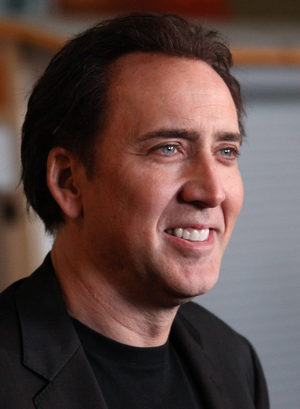

In [10]:
actor_image

The free version of the OMDB Api has a limit of **1000 calls a day**. Even the most prolific of famous actors such as Nicolas Cage (103), Michael Madsen (307), Better Midler (114), etc. don't come close to the 1000 a day limit.  
Although if anybody is interesting in viewing data about Mel Blanc (1149) or Mark Wood (1748) or other power-actors then functionality is provided to continue on over multiple days to build up the dataset.

In [146]:
def retrieve_credit_data_by_id(show_id: str) -> JsonType:
    """
    Movie data by imdb id

    keyword arguments:
    show_id: str - imdb id value for a movie/tv show

    Return: JsonType - JSON data from the API
    """
    omdb_url: str = f"http://www.omdbapi.com/?apikey={OMDB_API_KEY}&i={show_id}"
    return requests.get(omdb_url).json()

In [172]:
credits: List[JsonType] = []
CHECKPOINT: int = 0

In [259]:
def safe_retrieve_credit_data(credit_ids: List[str], checkpoint: int) -> int:
    """
    Retrieve data. If there is an error note the breakpoint
    to continue from in subsequent runs

    There are some Ids that randomly don't work for the OMDB Api
    and return a generic error so need to be filtered out

    Keyword argument:
    credit_ids: List[str] - List of the IMDB Ids for movies and tv shows
    checkpoint: int - The checkpoint number to carry on from

    Return: int - the checkpoint index
    """
    for m_id in credit_ids[checkpoint:]:
        res = retrieve_credit_data_by_id(m_id)
        if 'Limit Reached' in res.get('Error', ''):
            print(res.get('Error'))
            return checkpoint
        if res.get('Title', False):
            credits.append(res)
            checkpoint += 1
    return checkpoint

In [183]:
CHECKPOINT = safe_retrieve_credit_data(credit_ids=credit_ids, checkpoint=CHECKPOINT)

#### Structure of API responses
Example of a single credit and how it looks can be seen in the cell below.  Some of the fields will be useful for data analysis such as `imdbRating` and `Year`, some of the other fields will have to be filtered away as they don't provide interesting information for analysis such as `Plot` and the `Poster` link.

In [14]:
credits[-1]

{'Title': 'Best of Times',
 'Year': '1981',
 'Rated': 'N/A',
 'Released': 'N/A',
 'Runtime': '95 min',
 'Genre': 'Comedy',
 'Director': 'Don Mischer',
 'Writer': 'Bob Arnott, Carol Hatfield, Lane Sarasohn',
 'Actors': 'Crispin Glover, Jill Schoelen, Nicolas Cage, Julie Piekarski',
 'Plot': "Here's the lives of 7 teenage friends in 1981, singing, dancing and breaking the 4th wall.",
 'Language': 'English',
 'Country': 'USA',
 'Awards': 'N/A',
 'Poster': 'https://m.media-amazon.com/images/M/MV5BNjZlYTFiMzgtZWYwMS00OTExLWI3YmQtYTc5YzlmYzJiMTI0XkEyXkFqcGdeQXVyMzU0NzkwMDg@._V1_SX300.jpg',
 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '5.5/10'}],
 'Metascore': 'N/A',
 'imdbRating': '5.5',
 'imdbVotes': '197',
 'imdbID': 'tt0082064',
 'Type': 'movie',
 'DVD': 'N/A',
 'BoxOffice': 'N/A',
 'Production': 'N/A',
 'Website': 'N/A',
 'Response': 'True'}

In [147]:
def write_credits_data_to_csv(credits: JsonType) -> None:
    """
    Convert movie data from json to csv and write to file

    Keyword arguments:
    credits: JsonType - JSON data from the OMDB API

    Return: None
    """
    with open('credits_data.csv', 'w') as credits_file:
        csv_writer = csv.DictWriter(credits_file, fieldnames=list(credits[0].keys()), delimiter=',')
        csv_writer.writeheader()
        for credit in credits:
            csv_writer.writerow(credit)

In [16]:
write_credits_data_to_csv(credits=credits)

## Analysing the Data
The data stored about the actor's credits was stored in a `csv` file and it can easily be read into a `DataFrame` with the `Pandas` python library.  
The `DataFrame` is the preferred Data Structure for data analysis organising data into a table that can be read by row or column and operations can be efficiently and quickly performed on the rows and columns.

In [292]:
# Read csv file into pandas dataframe
credits = pd.read_csv('credits_data.csv')

In [293]:
num_instances, num_attributes = credits.shape
print(f"Number of instances: {num_instances}\nNumber of attributes: {num_attributes}")

Number of instances: 102
Number of attributes: 25


A summary of the data can be seen using the `head` method on the `credits` `DataFrame`. The first couple of values in the dataset have a lot of `NaN` values as the most recent credits for an actor tend to be movies or tv shows that are yet to be released so columns such as `Rated`, `Rating`, `Awards` etc. are not yet applicable or available.

In [294]:
pd.set_option('display.max_columns', 100)
credits.head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
0,10 Double Zero,2017,NaN,NaN,NaN,Crime,Christian Sesma,"Christian Sesma, Paul Sloan, Nick Vallelonga",NaN,DET. DANA REEVES is infamous for crossing the ...,English,USA,NaN,NaN,[],NaN,NaN,NaN,tt5843576,movie,NaN,NaN,NaN,NaN,True
1,The Croods 2,2020,NaN,23 Dec 2020,NaN,"Animation, Adventure, Comedy, Family, Fantasy",Joel Crawford,"Kirk DeMicco (creator), Dan Hageman (screenpla...","Nicolas Cage, Ryan Reynolds, Emma Stone, Kat D...",The prehistoric family the Croods are challeng...,English,USA,NaN,https://m.media-amazon.com/images/M/MV5BNTc1M2...,[],NaN,NaN,NaN,tt2850386,movie,NaN,NaN,20th Century Fox,NaN,True
2,Pig,2020,NaN,NaN,NaN,Drama,Michael Sarnoski,"Vanessa Block, Michael Sarnoski, Michael Sarnoski","Nicolas Cage, Alex Wolff, Adam Arkin, Nina Bel...",A truffle hunter who lives alone in the Oregon...,English,USA,NaN,NaN,[],NaN,NaN,NaN,tt11003218,movie,NaN,NaN,NaN,NaN,True
3,Prisoners of the Ghostland,2020,NaN,NaN,NaN,"Action, Horror, Thriller",Sion Sono,"Aaron Hendry, Reza Sixo Safai (screenplay)","Nicolas Cage, Sofia Boutella, Ed Skrein, Teres...",A notorious criminal must break an evil curse ...,English,"Japan, USA",NaN,https://m.media-amazon.com/images/M/MV5BNWQ0NT...,[],NaN,NaN,NaN,tt6372694,movie,NaN,NaN,NaN,NaN,True
4,Jiu Jitsu,2020,NaN,09 Jul 2020,NaN,"Action, Fantasy",Dimitri Logothetis,"Dimitri Logothetis (Writer), Jim McGrath (Writer)","Nicolas Cage, Marie Avgeropoulos, Frank Grillo...",A new Sci-Fi Martial Arts franchise from Dimit...,NaN,USA,NaN,https://m.media-amazon.com/images/M/MV5BYjFlMG...,[],NaN,NaN,NaN,tt9624766,movie,NaN,NaN,NaN,NaN,True


### Sanitising the Data
First of all some of the columns are not needed or provide useless information. Other columns need the data to be parsed and converted to a suitable format such as removing `min` after each number for the `Runtime` colour

Drop non-useful columns from the dataset.  
Drop:
- Genre
- Actors
- Writer
- Plot
- Language
- Country
- Awards
- Poster
- Ratings
- imdbID
- Type
- DVD
- Response
- Website

In [295]:
credits = credits.drop(['Genre', 'Writer', 'Actors',
                        'Plot', 'Language', 'Country',
                        'Awards', 'Poster', 'Ratings',
                        'imdbID', 'Type', 'DVD',
                        'Website', 'Response'], axis=1)

Clean up `Runtime`, `imdbVotes` and `BoxOffice` columns from strings to appropriate floats.  
`Runtime` needs to remove ` min` from the end of the time value strings. `imdbVotes` needs to have the commas in the strings removed as they were used for reading large numbers. `BoxOffice` was in a similar position to `imdbVotes` but its unit was dollars so also had a dollar sign infront of the amounts. Also note that a lot of credits did not have a `BoxOffice` value filled in. Finally the `Rated` value had to be converted to ordinal numeric data so calculations and plots can be produced

In [296]:
credits['Runtime'] = credits['Runtime'].apply(lambda x: float(x.replace(' min', '')) if type(x) == str else x)

In [297]:
credits['imdbVotes'] = credits['imdbVotes'].apply(lambda x: float(x.replace(',', '')) if type(x) != float and ',' in x else float(x))

In [298]:
credits['BoxOffice'] = credits['BoxOffice'].apply(lambda x: float(re.sub('\$|,', '', x)) if type(x) != float else x)

In [299]:
rating_map: Dict[str, Union[int, float]] = {
    'Not Rated': np.nan,
    'PG': 0.0,
    'PG-13': 1.0,
    'R': 2.0,
    'Unrated': 2.0,
    'TV-MA': 3.0,
    'NC-17': 3.0
}

In [300]:
credits = credits.replace({'Rated': rating_map})

In [303]:
credits['Rated'] = credits['Rated'].apply(lambda x: float(x))

An example of what the data looks like now it has been cleaned.  I have reversed the dataframe just so good example values can be seen. From the newest back there are a lot of NaN as the movies are yet to be released, as mentioned above

In [263]:
credits[::-1].head()

,Title,Year,Rated,Released,Runtime,Director,Metascore,imdbRating,imdbVotes,BoxOffice,Production
101,Best of Times,1981,NaN,NaN,95.0,Don Mischer,NaN,5.5,197.0,NaN,NaN
100,Fast Times at Ridgemont High,1982,2,13 Aug 1982,90.0,Amy Heckerling,67.0,7.2,88281.0,NaN,Universal Pictures
99,Valley Girl,1983,2,29 Apr 1983,99.0,Martha Coolidge,66.0,6.4,12171.0,NaN,MGM Home Entertainment
98,Rumble Fish,1983,2,21 Oct 1983,94.0,Francis Ford Coppola,63.0,7.2,30114.0,NaN,Universal Pictures
97,Racing with the Moon,1984,0,23 Mar 1984,108.0,Richard Benjamin,NaN,6.7,3853.0,NaN,Paramount Home Video


## Analysis and what does the data look like?
In this section I will take a look at the data and see what significant results can be taken from the data. Note that I performed the personal analysis based on data from **Nicolas Cage** so changing the `ACTOR_NAME` and running the notebook down to this point will possibly produce different results than data would indicate for **Nicolas Cage's** acting credits

The `DataFrame` has now been cleaned down to the most important fields. Describing the data we get some interesting points straight away.  
The first point that becomes apparent is the difference between the `Metascore` count and the `imdbRating` count. 20 more credits have an `imdbRating` but don't have a `Metascore` rating so going forward in the analysis I will use primarily the `imdbRating` for a credit's rating to get better results due to the extra data. Interestingly enough too the `Metascore` and the `imdbRating` diff with IMDB giving on average a lot higher ratings with `59%` compared to Metacritic's `49.9%`. Metacritic's reviews are more varied as they win when it comes to `min` (`12%` compared to `31%`), max (`87%` compared to `84%`) and the standard deviation supporting the view that the data is more spread out (`18.4%` compared to `10.7%`).  
The columns where the values are of type `object` (text fields such as `Title`) don't show much useful information as the bottom half of the describe results are designed to work on `float` type data.  
`BoxOffice` while being a `float` type does not clear info due to different exponentials being used as the box office take in generally exceeds a couple million.  
I will go more in depth into the data below.

In [305]:
credits.describe(include='all')

,Title,Year,Rated,Released,Runtime,Director,Metascore,imdbRating,imdbVotes,BoxOffice,Production
count,102,102.000000,87.000000,97,97.000000,102,77.000000,97.000000,97.000000,3.300000e+01,88
unique,102,NaN,NaN,97,NaN,88,NaN,NaN,NaN,NaN,54
top,Outcast,NaN,NaN,22 Dec 2000,NaN,Paul Schrader,NaN,NaN,NaN,NaN,Sony Pictures Home Entertainment
freq,1,NaN,NaN,1,NaN,3,NaN,NaN,NaN,NaN,6
mean,NaN,2004.990196,1.482759,NaN,105.164948,NaN,49.883117,5.944330,69495.814433,4.663337e+07,NaN
std,NaN,11.724980,0.760387,NaN,17.447947,NaN,18.475428,1.077127,94173.700043,5.764736e+07,NaN
min,NaN,1981.000000,0.000000,NaN,50.000000,NaN,12.000000,3.100000,20.000000,4.526000e+03,NaN
25%,NaN,1995.000000,1.000000,NaN,95.000000,NaN,35.000000,5.200000,6217.000000,1.070679e+07,NaN
50%,NaN,2007.000000,2.000000,NaN,101.000000,NaN,48.000000,6.000000,31559.000000,2.403304e+07,NaN
75%,NaN,2016.000000,2.000000,NaN,116.000000,NaN,66.000000,6.800000,91935.000000,6.314381e+07,NaN


The next step for data analysis is just doing a quite Pearson correlation for the float type objects against each other. Most of the values have weak to no relation with each other at all. A non surprising strong correlation was `Metascore` to `imdbRating` which you would hope be pretty similar to show the services provide an unbiased opinion of the movies and shows the actor has been in. The only other surprising correlation was that the `Rated` field has a strong negative correlation with `BoxOffice` take in money at `-0.7`. Which makes sense as we always hear big movie producers and executives complaining and trying to avoid producing `R` rated movies as the box office money drops the more graphic the movie or show gets.

In [318]:
credits.corr(method='pearson')

,Year,Rated,Runtime,Metascore,imdbRating,imdbVotes,BoxOffice
Year,1.000000,0.081756,-0.055867,-0.386582,-0.317142,0.003595,-0.229103
Rated,0.081756,1.000000,0.123199,-0.086306,-0.128881,-0.152208,-0.700655
Runtime,-0.055867,0.123199,1.000000,0.290068,0.386817,0.506032,0.093384
Metascore,-0.386582,-0.086306,0.290068,1.000000,0.755419,0.280595,-0.104113
imdbRating,-0.317142,-0.128881,0.386817,0.755419,1.000000,0.535331,0.102348
imdbVotes,0.003595,-0.152208,0.506032,0.280595,0.535331,1.000000,0.405677
BoxOffice,-0.229103,-0.700655,0.093384,-0.104113,0.102348,0.405677,1.000000


Plotting a scatter matrix to give us a visual representation of a correlation table will help find any relationships between objects that might not be visible from just a correlation.  For example we can see that Nicolas Cage has done mostly movies `Rated` 2 (R and Unrated). We can also see that there is a weak positive correlation with the number of votes a movie has on IMDB and its Runtime, with Nicolas Cage's shorter movies having a lot less votes.

(array([ 0.,  5., 10., 15., 20.]), <a list of 5 Text yticklabel objects>)

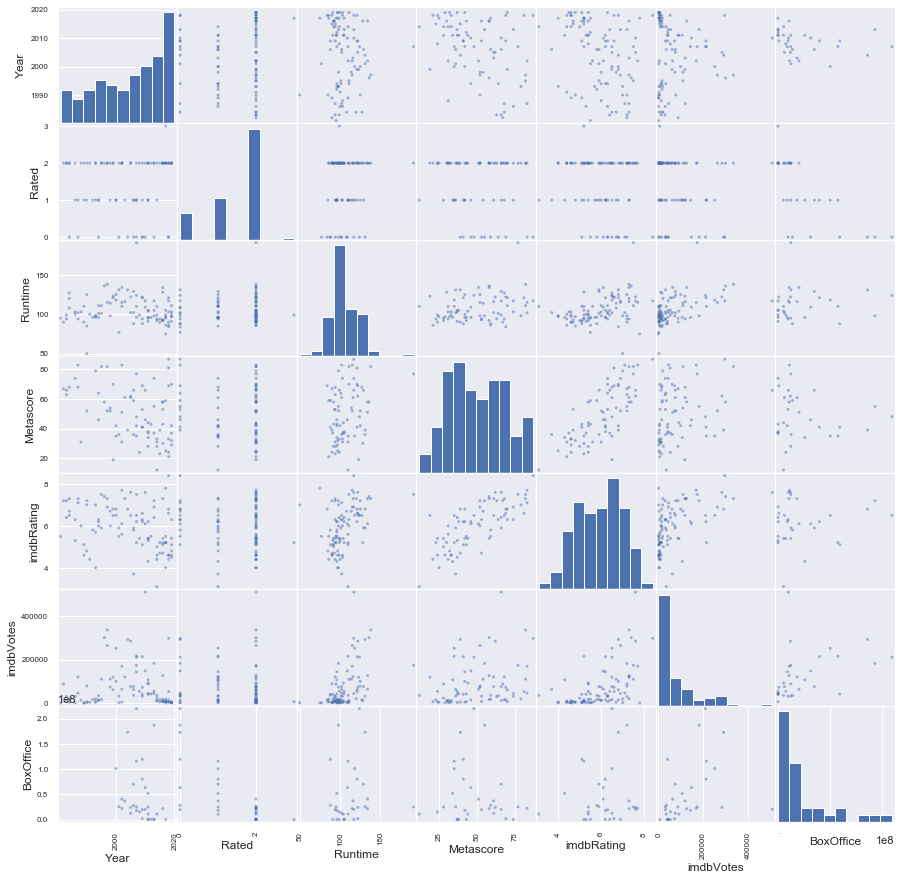

In [317]:
scatter_matrix: List[List[np.ndarray]] = pd.plotting.scatter_matrix(
    credits,
    figsize=[15, 15])
plt.xticks(fontsize=2, rotation=-90)
plt.yticks(fontsize=2)

The first in-detail plot is a scatter plot of Nicolas Cage's movie ratings by year. I have added a vertical red line at 2011 to mark approximately when Nicolas Cage fell into financial difficulty. After the red line there is a noticeable grouping of movies below a 6 rating as Nicolas Cage took on any offers for roles left and right to help pay his debts. But also noticeably Nicolas Cage taking any role available helped him appear in his 2 hightest rated movies of his career.

(0, 10)

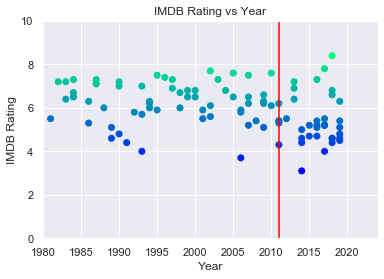

In [441]:
plt.scatter(credits['Year'], credits['imdbRating'], c=credits['imdbRating'], cmap='winter')
plt.axvline(x=2011, color='red')
plt.xlabel('Year')
plt.ylabel('IMDB Rating')
plt.title('IMDB Rating vs Year')

plt.gca().set_xlim([1980, 2024])
plt.gca().set_ylim([0, 10])

Plotting the `Runtime` against `imdbRating` doesn't provide any magical correlation but it does at least show us that most movies (at least the movies Nicolas Cage tends to star in) tend to be clumped at 2 hours long or slightly more than 1 and a half hours. The outliers at 50 minutes and 190 minutes stand out clearly. Movies have progressed over the years to be longer and have no doubt settled at this sweet spot between our two lines to produce the maximum profit from movie goers.  
To test this idea I plotted the `Runtime` versus the `BoxOffice` takings. The green shaded region represents a movie lasting between 90 minutes 120 minutes. The majority of the points line in the region or very close to the region, we can see 2 points to the left of the region for the box office takings plot but they are close enough to touch the shaded region. A couple of more points are to the right of the region but still within 20 minutes. With only one major outlier of 190 minutes we can say with a large amount of confidence that running time, to keep people's attention but also tell an interesting story, is choosen so as to give the best possible chance for a good box office profit.

Text(0.5, 1.0, 'Runtime vs Box Office Takings')

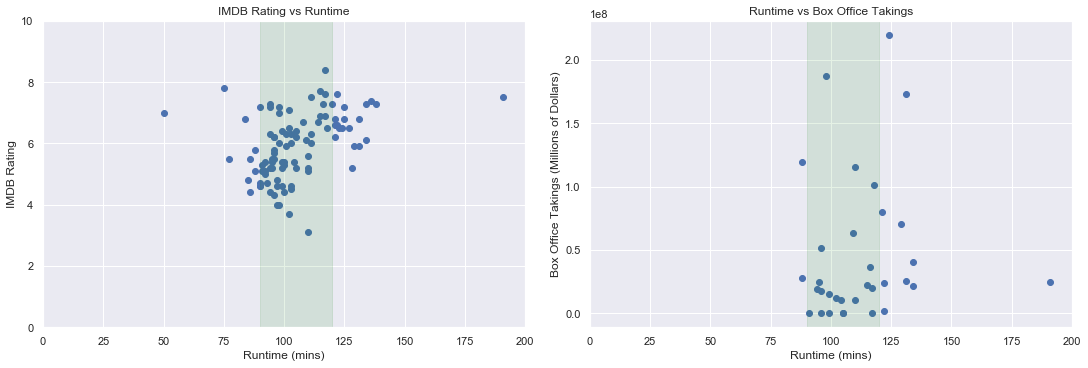

In [425]:
fig, (ax0, ax1) = plt.subplots(ncols=2, constrained_layout=True, figsize=(15, 5))
ax0.set_xlim([0, 200])
ax1.set_xlim([0, 200])

ax0.scatter(credits['Runtime'], credits['imdbRating'])
ax0.axvspan(90, 120, alpha=0.1, color='green') # Between 1 hour 30 minute mark and 2 hour mark
ax0.set_ylim([0, 10])
ax0.set_xlabel('Runtime (mins)')
ax0.set_ylabel('IMDB Rating')
ax0.set_title('IMDB Rating vs Runtime')

ax1.scatter(credits['Runtime'], credits['BoxOffice'])
ax1.axvspan(90, 120, alpha=0.1, color='green') # Between 1 hour 30 minute mark and 2 hour mark
ax1.set_xlabel('Runtime (mins)')
ax1.set_ylabel('Box Office Takings (Millions of Dollars)')
ax1.set_title('Runtime vs Box Office Takings')

Moving on to analysing the movies of Nicolas Cage based on their Maturity rating. As noted above in our map I have changed the string values of 'P', 'PG', etc. to a number value with the lowest maturity rating at a 0 and the highest most explicit ones at 4. Most of Nicolas Cage's movies, based on the histogram below, are in the value `2.0` representing R and Unrated movies. While I looked up the US film ratings that placed Unrated with R in terms of violence, etc. I feel that Unrated was also placed on a lot of movies that were not that explicit but just were not rated just to cost or whatever reason.  
The boxplot gives a little more insight into the maturity ratings for Nicolas Cage's films. On average his PG family friendly films achieved higher ratings with his best rating coming from a PG film. His PG-13 films, possibly by being quickly produced low budget films, performed the worst when it came to ratings.

Text(0.5, 1.0, 'Boxplot of IMDB Rating grouped by Maturity Rating')

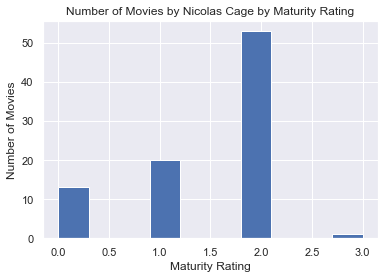

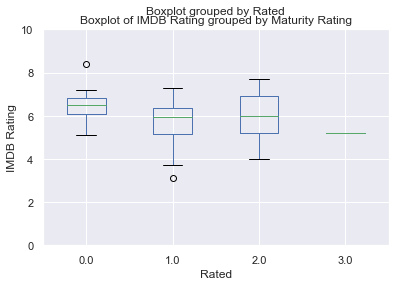

In [420]:
ax0 = credits['Rated'].hist()
ax0.set_xlabel('Maturity Rating')
ax0.set_ylabel('Number of Movies')
ax0.set_title('Number of Movies by Nicolas Cage by Maturity Rating')


ax1 = credits.boxplot(column=['imdbRating'], by='Rated')
ax1.set_ylabel('IMDB Rating')
ax1.set_ylim([0, 10])
ax1.set_title('Boxplot of IMDB Rating grouped by Maturity Rating')

Another interesting plot, shown below, involves plotting the `imdbRating` (multiplied by 10 to normalise to be out of 100) and the `Metascore` and seeing how the ratings differ. IMDB ratings generally have a lot more people rating the movies and on IMDB it is practically impossible to achieve a 100% rating, with the highest rated movie on the site being "Shawshank Redemption" with `9.2/10`. While Metacritic has critic scores but also user scores of a lower volume and at present 7 films have obtained a 100% rating on Metacritic.  

The translucent red line shows the average error. Movies below the green line (straight line through the origin to represent 1:1 correlation) indicate that they receive a higher rating on IMDB than on Metacritic and points above the green line indicate the opposite that they receive a better review on Metacritic. The second plots backs this up where the vast majority of bars on the plot are positive indicating IMDB gives a more favourable rating than the critics would say. This could indicate that the type of movies that Nicolas Cage acts in are made for a wide audience to be fun rather than artistic, beautiful and meaningful which the critics would look for in their films.

Text(0.5, 1.0, 'Margin of error in rating systems')

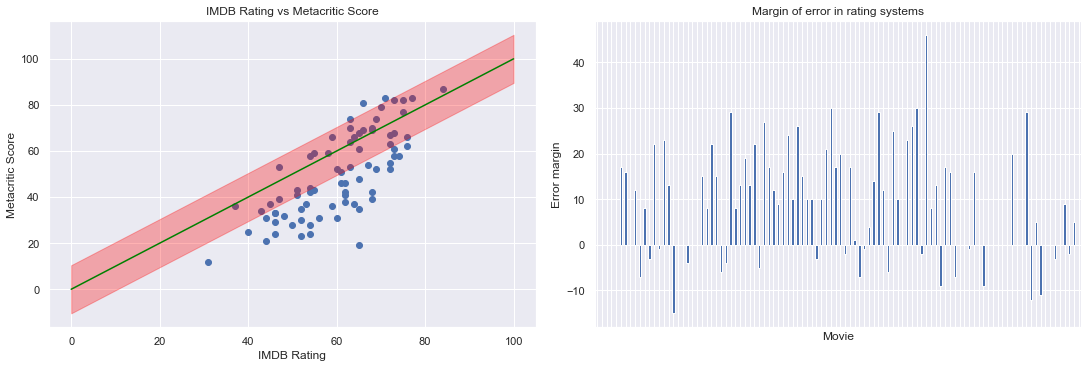

In [492]:
fig, (ax0, ax1) = plt.subplots(ncols=2, constrained_layout=True, figsize=(15, 5))
rating_error = credits['imdbRating'].mul(10) - credits['Metascore']

ax0.scatter(credits['imdbRating'].mul(10), credits['Metascore'])
xy = np.linspace(0, 100, 100)
ax0.plot(xy, xy, color='green')
ax0.fill_between(xy, xy+rating_error.mean(), xy-rating_error.mean(), color='red', alpha=0.3)
ax0.set_xlabel('IMDB Rating')
ax0.set_ylabel('Metacritic Score')
ax0.set_title('IMDB Rating vs Metacritic Score')

rating_error.plot(kind='bar') # plot error
ax1.set_xlabel('Movie')
ax1.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
ax1.set_ylabel('Error margin')
ax1.set_title('Margin of error in rating systems')


We can also perform a quick check for Nicolas Cage's highest rated movies by weighting both systems as equal and finding the resuls with better than a 75/100 score. We can see that for all these top movies the `Metascore` far surpasses the `imdbRating`.

In [463]:
credits[((credits['imdbRating']*10 + credits['Metascore'])/2) > 75]

,Title,Year,Rated,Released,Runtime,Director,Metascore,imdbRating,imdbVotes,BoxOffice,Production
11,Spider-Man: Into the Spider-Verse,2018,0.0,14 Dec 2018,117.0,"Bob Persichetti, Peter Ramsey, Rodney Rothman",87.0,8.4,296909.0,NaN,Sony Pictures
52,Grindhouse,2007,2.0,06 Apr 2007,191.0,"Robert Rodriguez, Eli Roth, Quentin Tarantino,...",77.0,7.5,173445.0,24928753.0,The Weinstein Co./Dimension
61,Adaptation.,2002,2.0,14 Feb 2003,115.0,Spike Jonze,83.0,7.7,168977.0,22184735.0,Columbia Pictures
72,Face/Off,1997,2.0,27 Jun 1997,138.0,John Woo,82.0,7.3,335884.0,NaN,Paramount Pictures
75,Leaving Las Vegas,1995,2.0,09 Feb 1996,111.0,Mike Figgis,82.0,7.5,109729.0,NaN,United Artists
91,Moonstruck,1987,0.0,15 Jan 1988,102.0,Norman Jewison,83.0,7.1,45696.0,NaN,MGM Home Entertainment


The boxplot of Ratings against the movie's Production Company can give us insight into the quality of movies that their produce. This could also help us predict later how Nicolas Cage's future movies will go based on what production company is funding it and giving their support to the filming.  

"20th Century Fox" has the highest mean but might be biased given the low number of movies that Nicolas Cage has done by "20th Century Fox". "Sony Pictures" has the largest range with the highest rated and lowest rated movies. "Columbia Pictures" has a decent number of samples but also quite a high mean, this is something to look out for if upcoming Nicolas Cage movies are by that Production Company.

Text(0.5, 1.0, 'Boxplot of IMDB Rating grouped by their Production Company')

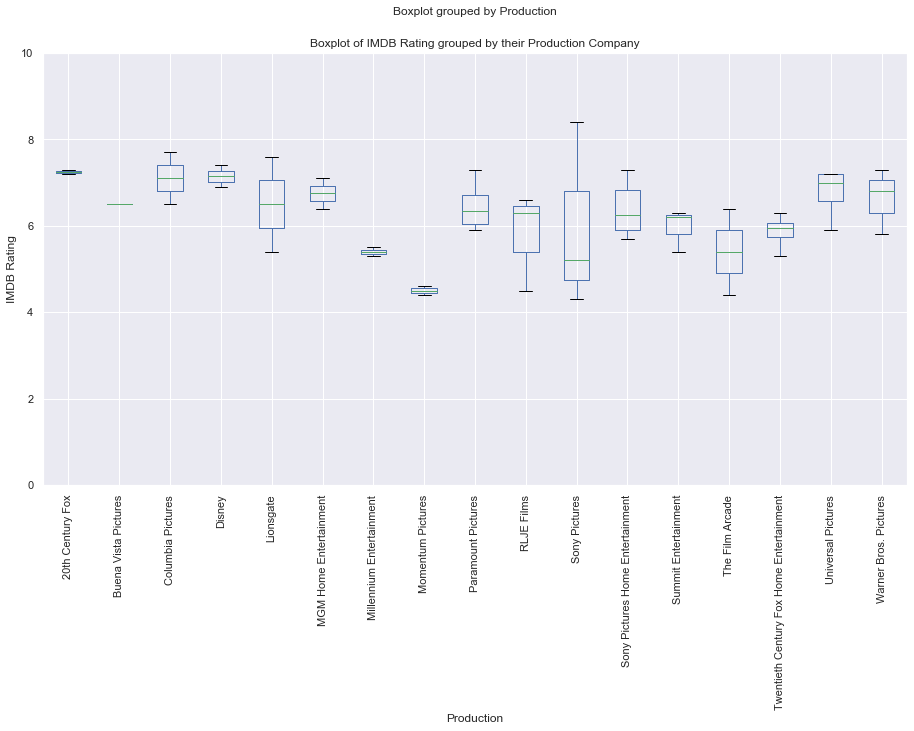

In [471]:
# Filter for only the Production Companies that Nicolas Cage has worked with more than once
common_productions = credits.groupby('Production').filter(lambda x: len(x) > 1)
ax0 = common_productions.boxplot(column=['imdbRating'], by='Production', figsize=(15, 8), rot=90)
ax0.set_ylabel('IMDB Rating')
ax0.set_ylim([0, 10])
ax0.set_title('Boxplot of IMDB Rating grouped by their Production Company')

A pivot table is used here below to keep a running total of the mean rating for Nicolas Cage's movies. On the graph the red line marks when he got into major financial difficulty and we can see from that point that his movie mean rating takes an on average decline. The green line however marks the high point of his career where he won his Oscar for "Leaving Las Vegas".

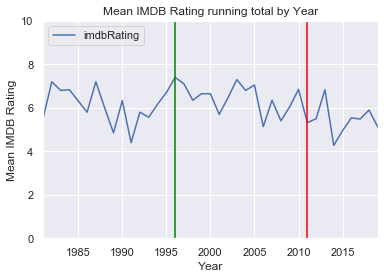

In [500]:
credits.pivot_table('imdbRating', index='Year', aggfunc='mean').plot()
plt.ylim([0, 10])
plt.ylabel('Mean IMDB Rating')
plt.title('Mean IMDB Rating running total by Year')
plt.axvline(x=2011, color='red')
plt.axvline(x=1996, color='green')

In [493]:
# Apply a Linear Regression onto value to plot the line of best fit
# Try to predict how good his upcoming movies will do based on info about them
# Try different inputs, multiple inputs such as Production Company

In [359]:
ratings = credits.dropna(subset=['imdbRating'], inplace=False)

In [360]:
model = LinearRegression()
years2D = ratings['Year'][:, np.newaxis][::-1]
print(years2D.shape)

(97, 1)


In [361]:
rates = list(ratings['imdbRating'])
model.fit(years2D, rates)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

(0, 10)

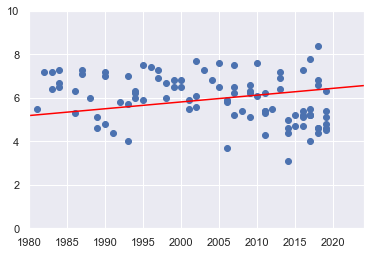

In [362]:
xfit = np.linspace(1980, 2024)
yfit = model.predict(xfit[:, np.newaxis])
plt.scatter(list(ratings['Year']), rates)
plt.plot(xfit, yfit, color='red')
ax = plt.gca()
ax.set_xlim([1980, 2024])
ax.set_ylim([0, 10])

In [47]:
model.intercept_

2024.4460837853348

In [79]:
model.coef_

array([0.03133381])

In [370]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)

yearsP = poly.fit_transform(ratings['Year'][:, np.newaxis][::-1])

In [373]:
modelp = LinearRegression().fit(yearsP, rates)
fitP = modelp.predict(yearsP)

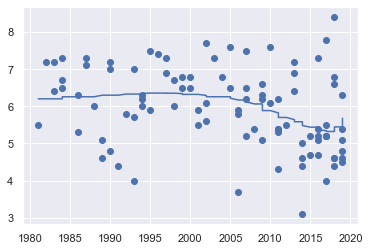

In [375]:
plt.scatter(list(ratings['Year']), rates)
plt.plot(list(ratings['Year']), fitP)

In [530]:
# Testing multivariate linear regression
credits.columns

Index(['Title', 'Year', 'Rated', 'Released', 'Runtime', 'Director',
       'Metascore', 'imdbRating', 'imdbVotes', 'BoxOffice', 'Production'],
      dtype='object')

In [583]:
credits['Production']

25                Open Road Films
31            Freestyle Releasing
34           Roadside Attractions
35                The Film Arcade
36               20th Century Fox
37       Millennium Entertainment
38                  Sony Pictures
39       Millennium Entertainment
40       Anchor Bay Entertainment
41           Summit Entertainment
42               Relativity Media
43            Walt Disney Studios
44                      Lionsgate
45           Summit Entertainment
46            First Look Pictures
47           Walt Disney Pictures
48           Summit Entertainment
49                      Lionsgate
50           Buena Vista Pictures
51             Paramount Pictures
52    The Weinstein Co./Dimension
53                  Sony Pictures
55             Paramount Pictures
56          Warner Bros. Pictures
57             Paramount Pictures
58                     Lions Gate
59                    Buena Vista
60          Warner Bros. Pictures
61              Columbia Pictures
63            

In [551]:
credits.dropna(inplace=True)
X = credits[['Year', 'Rated', 'Runtime', 'Production']]
Y = credits[['imdbRating']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 0)

In [553]:
mdl = LinearRegression()
mdl.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [555]:
mdl.coef_

array([[-2.36938412e-02,  3.13688960e-01, -5.94640026e-04,
         5.25399527e-02,  1.88724377e-06,  4.00651384e-09]])

In [556]:
ypred = mdl.predict(X_test)

In [559]:
ypred

array([[5.75999492],
       [7.09996883],
       [4.84602685],
       [7.33507798],
       [6.01835319],
       [7.22315111],
       [8.39377453]])

In [579]:
ytest = list(Y_test.iloc[:, 0])
print(ytest)

[6.1, 5.9, 5.4, 6.9, 6.2, 6.6, 7.7]


In [571]:
diff = pd.DataFrame({'Actual': ytest, 'Predicted': ypred[0]})

ValueError: arrays must all be same length